In [8]:
import sys

import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns 
import keras
import os
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.0-arm64-arm-64bit
Tensor Flow Version: 2.13.0
Keras Version: 2.13.1

Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
Pandas 2.1.1
Scikit-Learn 1.3.1
GPU is available


In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle


In [10]:
images = "./images/images/"
artists = list(os.listdir(images))
try:
    artists.remove('.DS_Store')
except:
    print("Doesn't Exist")

In [26]:
from tensorflow.keras.applications import inception_v3, vgg16, vgg19, efficientnet_v2, xception, inception_resnet_v2 
from tensorflow.keras.applications import InceptionV3, VGG16, VGG19, EfficientNetV2S, Xception, InceptionResNetV2

In [27]:
#modelobjs = [inception_v3, vgg16, vgg19, efficientnet_v2, xception, inception_resnet_v2, 
modelobjs = [InceptionV3, VGG16, VGG19, EfficientNetV2S, Xception, InceptionResNetV2 ]
modelfuncs = [InceptionV3, VGG16, VGG19, EfficientNetV2S, Xception, InceptionResNetV2]

### Visualisation

In [28]:
# fill in with code to visualise a facet grid to show some sample images
# make it re-usable so that augmented images can be viwed

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, horizontal_flip=True, vertical_flip=True, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(directory=images, class_mode="categorical", target_size=(224,224), batch_size=16, subset="training", shuffle=True, classes=artists)
valid_generator = train_datagen.flow_from_directory(directory=images, class_mode="categorical", target_size=(224,224), batch_size=16, subset="validation", shuffle=True, classes=artists)

Found 7042 images belonging to 51 classes.
Found 1732 images belonging to 51 classes.


In [ ]:
import matplotlib.pyplot as plt

# Access a batch of images from the training generator
sample_training_images, sample_training_labels = next(train_generator)

# Display a few sample images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):  # Displaying 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_training_images[i])
    plt.title(f"Label: {sample_training_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


### Loop Configuration Details
- Cycle through all the selected models in a loop and save data.
    - Add contigencies, so that if it fails it will atleast partially save the data.
- Print every odd cycle's feature maps ( save to a directory called feature maps per odd epoch )
- Save the Model History, weights, and model file at the end
- Save performance visualisations at the end ( conf mat, classification reports, train, validation loss and accuracy graphs, AUC ROC? ) 

----
### Idea: Training pipeline
- train the selective list of models, record the performance metrics.
- Do comparative performance analytics, select the good model out of the bunch. 
- Plug the model to Keras Tuner to find the optimal Hyperparameters 
- Compare the performance pre-and-post hyperparameter tuning

In [48]:
images

'./images/images/'

In [30]:
import time

model_histories = {}

# hyperparams
EPOCHS = 25
OPTIMIZER = 'adam'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['accuracy','AUC']
train_input_shape = (224, 224,3)


# CODE PARAMS
write_model_summary = True
display_intermediate_layers = True
display_network = False


# PATHS
base_path = './modeling-data-c51/'


param_dictionary = {"optimizer":OPTIMIZER, "loss_function": LOSS_FUNC, 'metrics': METRICS}

for model_func, model_obj in zip(modelfuncs, modelobjs):
    
    summary_write_flag = True
    # model name
    model_name = model_func.__name__
    print(model_name)
    
    # create directory
    model_data_path = os.path.join(base_path, model_name)
    os.makedirs(model_data_path, exist_ok=True)

    # Saving Model Histories
    model_histories[model_name] = param_dictionary
    
    base_model = model_obj(weights='imagenet', include_top=False, 
                           input_shape=train_input_shape)
    
    # Freezing Base Model to enable Transfer Learning
    base_model.trainable = False
    
    # Sequential
    network = Sequential(base_model)
    network.add(GlobalAveragePooling2D())
    
    network.add(BatchNormalization())
    network.add(Dropout(0.5))
    network.add(BatchNormalization())
    network.add(Dropout(0.5))
    network.add(Dense(51, activation='softmax'))
    
    network.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS, )
    
    # nick names 
    nick_name = model_name+"_c51"
    network._name = nick_name
    
    # Callback definition
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    csv_logger = CSVLogger(os.path.join(model_data_path, f'{nick_name}.log'))
    progbar_logger = ProgbarLogger()
    
    if display_network:
        print(network.summary(expand_nested=False, show_trainable=True))
        print('--'*25)
    else:
        if summary_write_flag: 
            with open(os.path.join(model_data_path, f"{nick_name}.txt"), 'a+') as f:
                network.summary(print_fn=lambda x: f.write(x + '\n'), expand_nested=False, show_trainable=True)
            summary_write_flag = False
    
    start = time.time()
    network.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator,
                callbacks=[reduce_lr, early_stopping, csv_logger, progbar_logger])
    elapsed = time.time() - start
    
    # model history 
    model_histories['History'] = network.history.history
    model_histories['elapsed'] = elapsed
    
    # saving 
    print(f"{nick_name} saving data..")
    with open(os.path.join(model_data_path, f"{model_name}_configuration.pickle"),"wb") as file:
        pickle.dump(model_histories, file)
        
    print(f"{nick_name} .. saved!")
    print("--"*25)
    
    # save model.keras
    network.save(os.path.join(model_data_path, f"{nick_name}.keras"))
    # save base_model.keras
    base_model.save(os.path.join(model_data_path, f"{model_name}.keras"))
    # tf folder
    network.save(os.path.join(model_data_path, f"{nick_name}"))
    
    

InceptionV3
Epoch 1/25


2023-11-20 21:07:25.546933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 82s 0s/sample - loss: 4.2831 - accuracy: 0.2149 - auc: 0.7554

2023-11-20 21:08:45.857410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - 118s 269ms/sample - loss: 4.2831 - accuracy: 0.2149 - auc: 0.7554 - val_loss: 2.3374 - val_accuracy: 0.3816 - val_auc: 0.9099 - lr: 0.0010
Epoch 2/25
441/441 [==============================] - 72s 163ms/sample - loss: 3.0738 - accuracy: 0.3567 - auc: 0.8515 - val_loss: 2.1495 - val_accuracy: 0.4232 - val_auc: 0.9234 - lr: 0.0010
Epoch 3/25
441/441 [==============================] - 71s 161ms/sample - loss: 2.7690 - accuracy: 0.3959 - auc: 0.8760 - val_loss: 2.0903 - val_accuracy: 0.4238 - val_auc: 0.9248 - lr: 0.0010
Epoch 4/25
441/441 [==============================] - 71s 162ms/sample - loss: 2.5251 - accuracy: 0.4389 - auc: 0.8919 - val_loss: 2.0864 - val_accuracy: 0.4365 - val_auc: 0.9258 - lr: 0.0010
Epoch 5/25
441/441 [==============================] - 72s 162ms/sample - loss: 2.4632 - accuracy: 0.4473 - auc: 0.8946 - val_loss: 2.0626 - val_accuracy: 0.4532 - val_auc: 0.9269 - lr: 0.0010
Epoch 6/25
441/441 [==============================

INFO:tensorflow:Assets written to: ./modeling-data-c51/InceptionV3/InceptionV3_c51/assets


VGG16
Epoch 1/25


2023-11-20 21:35:45.281747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 68s 0s/sample - loss: 4.0160 - accuracy: 0.1742 - auc: 0.7478

2023-11-20 21:36:52.815200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - 86s 196ms/sample - loss: 4.0160 - accuracy: 0.1742 - auc: 0.7478 - val_loss: 2.9300 - val_accuracy: 0.3337 - val_auc: 0.8939 - lr: 0.0010
Epoch 2/25
441/441 [==============================] - 73s 165ms/sample - loss: 2.8620 - accuracy: 0.2976 - auc: 0.8586 - val_loss: 2.5338 - val_accuracy: 0.3747 - val_auc: 0.9107 - lr: 0.0010
Epoch 3/25
441/441 [==============================] - 73s 165ms/sample - loss: 2.5220 - accuracy: 0.3569 - auc: 0.8910 - val_loss: 2.4180 - val_accuracy: 0.4226 - val_auc: 0.9196 - lr: 0.0010
Epoch 4/25
441/441 [==============================] - 73s 166ms/sample - loss: 2.3091 - accuracy: 0.3796 - auc: 0.9072 - val_loss: 2.3758 - val_accuracy: 0.4296 - val_auc: 0.9257 - lr: 0.0010
Epoch 5/25
441/441 [==============================] - 73s 166ms/sample - loss: 2.1697 - accuracy: 0.4107 - auc: 0.9199 - val_loss: 2.3403 - val_accuracy: 0.4365 - val_auc: 0.9279 - lr: 0.0010
Epoch 6/25
441/441 [==============================]

INFO:tensorflow:Assets written to: ./modeling-data-c51/VGG16/VGG16_c51/assets


VGG19
Epoch 1/25


2023-11-20 22:16:43.937321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 68s 0s/sample - loss: 4.0802 - accuracy: 0.1656 - auc: 0.7412

2023-11-20 22:17:51.882374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - 87s 198ms/sample - loss: 4.0802 - accuracy: 0.1656 - auc: 0.7412 - val_loss: 2.9554 - val_accuracy: 0.3430 - val_auc: 0.8931 - lr: 0.0010
Epoch 2/25
441/441 [==============================] - 74s 167ms/sample - loss: 2.9137 - accuracy: 0.2843 - auc: 0.8562 - val_loss: 2.5957 - val_accuracy: 0.3528 - val_auc: 0.9058 - lr: 0.0010
Epoch 3/25
441/441 [==============================] - 73s 166ms/sample - loss: 2.5611 - accuracy: 0.3333 - auc: 0.8888 - val_loss: 2.5255 - val_accuracy: 0.3845 - val_auc: 0.9116 - lr: 0.0010
Epoch 4/25
441/441 [==============================] - 74s 167ms/sample - loss: 2.3910 - accuracy: 0.3513 - auc: 0.9048 - val_loss: 2.4764 - val_accuracy: 0.3891 - val_auc: 0.9184 - lr: 0.0010
Epoch 5/25
441/441 [==============================] - 74s 168ms/sample - loss: 2.2679 - accuracy: 0.3779 - auc: 0.9134 - val_loss: 2.4362 - val_accuracy: 0.4018 - val_auc: 0.9235 - lr: 0.0010
Epoch 6/25
441/441 [==============================]

INFO:tensorflow:Assets written to: ./modeling-data-c51/VGG19/VGG19_c51/assets


EfficientNetV2S
Epoch 1/25


2023-11-20 22:33:12.411989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 501s 0s/sample - loss: 4.7207 - accuracy: 0.0870 - auc: 0.6686

2023-11-20 22:41:30.699400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - 1534s 3s/sample - loss: 4.7207 - accuracy: 0.0870 - auc: 0.6686 - val_loss: 3.8333 - val_accuracy: 0.0462 - val_auc: 0.6181 - lr: 0.0010
Epoch 2/25
441/441 [==============================] - 989s 2s/sample - loss: 4.2953 - accuracy: 0.1226 - auc: 0.7240 - val_loss: 3.5777 - val_accuracy: 0.0941 - val_auc: 0.7277 - lr: 0.0010
Epoch 3/25
441/441 [==============================] - 76s 172ms/sample - loss: 4.1190 - accuracy: 0.1271 - auc: 0.7356 - val_loss: 3.5438 - val_accuracy: 0.1184 - val_auc: 0.7413 - lr: 0.0010
Epoch 4/25
441/441 [==============================] - 76s 173ms/sample - loss: 3.9748 - accuracy: 0.1376 - auc: 0.7498 - val_loss: 3.5594 - val_accuracy: 0.0820 - val_auc: 0.7373 - lr: 0.0010
Epoch 5/25
441/441 [==============================] - 75s 171ms/sample - loss: 3.8797 - accuracy: 0.1400 - auc: 0.7596 - val_loss: 3.4929 - val_accuracy: 0.0987 - val_auc: 0.7653 - lr: 0.0010
Epoch 6/25
441/441 [==============================] - 

INFO:tensorflow:Assets written to: ./modeling-data-c51/EfficientNetV2S/EfficientNetV2S_c51/assets


INFO:tensorflow:Assets written to: ./modeling-data-c51/EfficientNetV2S/EfficientNetV2S_c51/assets


Xception
Epoch 1/25


2023-11-20 23:23:08.840889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 84s 0s/sample - loss: 4.1244 - accuracy: 0.2340 - auc: 0.7707

2023-11-20 23:24:30.561150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - 115s 261ms/sample - loss: 4.1244 - accuracy: 0.2340 - auc: 0.7707 - val_loss: 2.2708 - val_accuracy: 0.3961 - val_auc: 0.9218 - lr: 0.0010
Epoch 2/25
441/441 [==============================] - 104s 235ms/sample - loss: 2.9824 - accuracy: 0.3806 - auc: 0.8567 - val_loss: 2.1267 - val_accuracy: 0.4203 - val_auc: 0.9258 - lr: 0.0010
Epoch 3/25
441/441 [==============================] - 252s 571ms/sample - loss: 2.6778 - accuracy: 0.4178 - auc: 0.8812 - val_loss: 2.0342 - val_accuracy: 0.4330 - val_auc: 0.9350 - lr: 0.0010
Epoch 4/25
441/441 [==============================] - 346s 784ms/sample - loss: 2.4625 - accuracy: 0.4467 - auc: 0.8962 - val_loss: 2.0297 - val_accuracy: 0.4503 - val_auc: 0.9306 - lr: 0.0010
Epoch 5/25
441/441 [==============================] - 170s 386ms/sample - loss: 2.3178 - accuracy: 0.4781 - auc: 0.9049 - val_loss: 2.0742 - val_accuracy: 0.4249 - val_auc: 0.9308 - lr: 0.0010
Epoch 6/25
441/441 [==========================

INFO:tensorflow:Assets written to: ./modeling-data-c51/Xception/Xception_c51/assets


InceptionResNetV2
Epoch 1/25


2023-11-21 00:19:39.530882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 369s 0s/sample - loss: 4.1426 - accuracy: 0.2106 - auc: 0.7602

2023-11-21 00:25:46.469207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - 462s 1s/sample - loss: 4.1426 - accuracy: 0.2106 - auc: 0.7602 - val_loss: 2.3203 - val_accuracy: 0.3828 - val_auc: 0.9134 - lr: 0.0010
Epoch 2/25
441/441 [==============================] - 76s 173ms/sample - loss: 2.9722 - accuracy: 0.3462 - auc: 0.8569 - val_loss: 2.1507 - val_accuracy: 0.4122 - val_auc: 0.9267 - lr: 0.0010
Epoch 3/25
441/441 [==============================] - 74s 169ms/sample - loss: 2.6523 - accuracy: 0.3929 - auc: 0.8822 - val_loss: 2.0748 - val_accuracy: 0.4428 - val_auc: 0.9332 - lr: 0.0010
Epoch 4/25
441/441 [==============================] - 74s 169ms/sample - loss: 2.4319 - accuracy: 0.4186 - auc: 0.8973 - val_loss: 2.0311 - val_accuracy: 0.4544 - val_auc: 0.9355 - lr: 0.0010
Epoch 5/25
441/441 [==============================] - 76s 173ms/sample - loss: 2.3203 - accuracy: 0.4398 - auc: 0.9057 - val_loss: 1.9815 - val_accuracy: 0.4752 - val_auc: 0.9364 - lr: 0.0010
Epoch 6/25
441/441 [==============================] -

INFO:tensorflow:Assets written to: ./modeling-data-c51/InceptionResNetV2/InceptionResNetV2_c51/assets


### Optimizing 

In [11]:
artists = pd.read_csv("artists.csv")

In [12]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [28]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [35]:
# Explore images of top artists
images_dir = './images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ./images/images/Vincent_van_Gogh
Found --> ./images/images/Edgar_Degas
Found --> ./images/images/Pablo_Picasso
Found --> ./images/images/Pierre-Auguste_Renoir
Found --> ./images/images/Albrecht_Dürer
Found --> ./images/images/Paul_Gauguin
Found --> ./images/images/Francisco_Goya
Found --> ./images/images/Rembrandt
Found --> ./images/images/Alfred_Sisley
Found --> ./images/images/Titian
Found --> ./images/images/Marc_Chagall


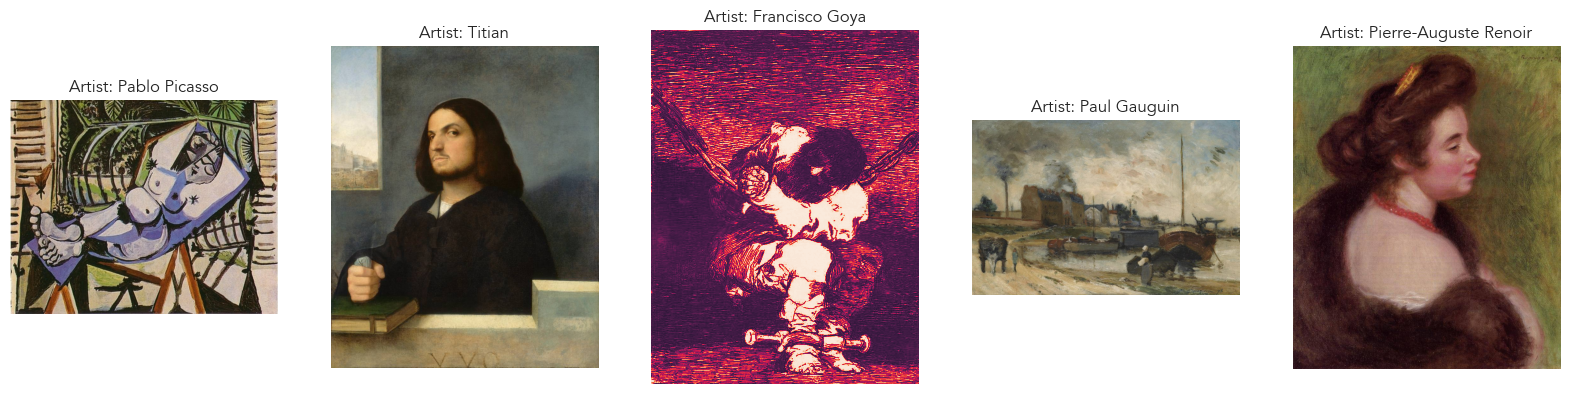

In [36]:
# Print few random paintings
import matplotlib.pyplot as plt
import random
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'avenir'
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [37]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


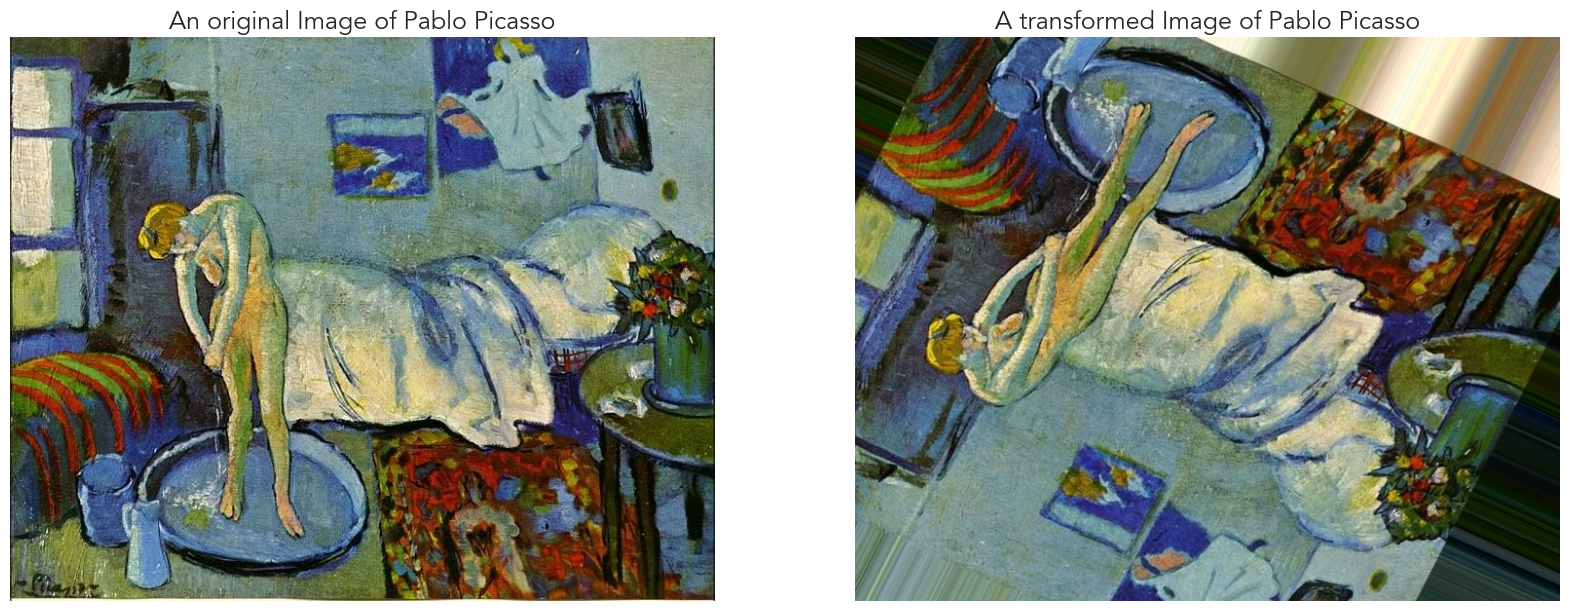

In [38]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '), size=18)
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '), size=18)
axes[1].axis('off')

plt.show()

### Fine-Tuning the selected models

In [12]:
optimal_models = ['InceptionV3','InceptionResNetV2','Xception']
model_base_path = "./modeling-data-c51/"

In [15]:
from tensorflow.keras.models import load_model

In [14]:
# load models 
pre_trained_model_files = {}
for md in optimal_models:
    print(f"{md}: ",end="")
    model_path = os.path.join(model_base_path,md, md+"_c51.keras")
    try:
        pre_trained_model_files[f"{md}_c11"] = load_model(model_path, compile=False)
        print("loaded!")
    except:
        print("failed to load!")

InceptionV3: 

2023-11-23 23:29:23.735328: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-23 23:29:23.735350: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-23 23:29:23.735357: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-23 23:29:23.735388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 23:29:23.735403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


loaded!
InceptionResNetV2: loaded!
Xception: loaded!


In [24]:
# readjusting the output layers to 11 
adjusted_pretrained = {}
for md_name, obj in zip(pre_trained_model_files.keys(), pre_trained_model_files.values()):
    print(md_name)
    obj.pop()
    new_output = Dense(11, activation='softmax')
    obj.add(new_output)
    adjusted_pretrained[md_name] = obj
    obj._name = md_name
    obj.summary()
    print('*****'*50)

InceptionV3_c11
Model: "InceptionV3_c11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_672 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 batch_normalization_673 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                   

In [27]:
import time

model_histories = {}

# hyperparams
EPOCHS = 30
OPTIMIZER = 'adam'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['accuracy','AUC']
train_input_shape = (224, 224,3)


# CODE PARAMS
write_model_summary = True
display_intermediate_layers = True
display_network = False


# PATHS
base_path = './modeling-data-c11/'
os.makedirs(base_path, exist_ok=True)

param_dictionary = {"optimizer":OPTIMIZER, "loss_function": LOSS_FUNC, 'metrics': METRICS}

for model_name, model_obj in zip(adjusted_pretrained.keys(), adjusted_pretrained.values()):
    
    summary_write_flag = True
    # model name
    
    print(model_name)
    
    # create directory
    model_data_path = os.path.join(base_path, model_name)
    os.makedirs(model_data_path, exist_ok=True)

    # Saving Model Histories
    model_histories[model_name] = param_dictionary
    
    
    model_obj.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS, )
    
    # Callback definition
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    csv_logger = CSVLogger(os.path.join(model_data_path, f'{model_name}.log'))
    progbar_logger = ProgbarLogger()
    
    if display_network:
        print(model_obj.summary(expand_nested=False, show_trainable=True))
        print('--'*25)
    else:
        if summary_write_flag: 
            with open(os.path.join(model_data_path, f"{model_name}.txt"), 'a+') as f:
                model_obj.summary(print_fn=lambda x: f.write(x + '\n'), expand_nested=False, show_trainable=True)
            summary_write_flag = False
    
    start = time.time()
    
    model_obj.fit_generator(generator=train_generator, 
                              validation_data=valid_generator, 
                              epochs=EPOCHS,
                              shuffle=True,
                              callbacks=[reduce_lr, early_stopping, csv_logger, progbar_logger],
                             )

    elapsed = time.time() - start
    
    # model history 
    model_histories['History'] = model_obj.history.history
    model_histories['elapsed'] = elapsed
    
    # saving 
    print(f"{model_name} saving data..")
    with open(os.path.join(model_data_path, f"{model_name}_configuration.pickle"),"wb") as file:
        pickle.dump(model_histories, file)
        
    print(f"{model_name} .. saved!")
    print("--"*25)
    
    # save model.keras
    model_obj.save(os.path.join(model_data_path, f"{model_name}.keras"))
    # tf folder
    model_obj.save(os.path.join(model_data_path, f"{model_name}"))
    
                                       

InceptionV3_c11
Epoch 1/30


/var/folders/5r/pnlff12n2d55g65_tnn3b1pw0000gn/T/ipykernel_96990/2109790810.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_obj.fit_generator(generator=train_generator,
2023-11-23 23:52:04.525048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 55s 0s/sample - loss: 1.1809 - accuracy: 0.6249 - auc: 0.9348

2023-11-23 23:52:58.605525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


216/216 [==============================] - 83s 384ms/sample - loss: 1.1809 - accuracy: 0.6249 - auc: 0.9348 - val_loss: 1.0573 - val_accuracy: 0.6281 - val_auc: 0.9456 - lr: 0.0010
Epoch 2/30
216/216 [==============================] - 38s 176ms/sample - loss: 1.1900 - accuracy: 0.6263 - auc: 0.9326 - val_loss: 1.0336 - val_accuracy: 0.6784 - val_auc: 0.9478 - lr: 0.0010
Epoch 3/30
216/216 [==============================] - 38s 175ms/sample - loss: 1.1713 - accuracy: 0.6373 - auc: 0.9343 - val_loss: 1.0473 - val_accuracy: 0.6491 - val_auc: 0.9469 - lr: 0.0010
Epoch 4/30
216/216 [==============================] - 38s 175ms/sample - loss: 1.1665 - accuracy: 0.6440 - auc: 0.9343 - val_loss: 1.0436 - val_accuracy: 0.6585 - val_auc: 0.9481 - lr: 0.0010
Epoch 5/30
216/216 [==============================] - 38s 175ms/sample - loss: 1.1443 - accuracy: 0.6376 - auc: 0.9365 - val_loss: 1.0275 - val_accuracy: 0.6491 - val_auc: 0.9497 - lr: 0.0010
Epoch 6/30
216/216 [==============================]

INFO:tensorflow:Assets written to: ./modeling-data-c11/InceptionV3_c11/InceptionV3_c11/assets


InceptionResNetV2_c11
Epoch 1/30


/var/folders/5r/pnlff12n2d55g65_tnn3b1pw0000gn/T/ipykernel_96990/2109790810.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_obj.fit_generator(generator=train_generator,
2023-11-24 00:09:13.374943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 191s 0s/sample - loss: 2.0721 - accuracy: 0.3763 - auc: 0.8106

2023-11-24 00:12:22.538803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


216/216 [==============================] - 288s 1s/sample - loss: 2.0721 - accuracy: 0.3763 - auc: 0.8106 - val_loss: 1.3705 - val_accuracy: 0.5509 - val_auc: 0.9121 - lr: 0.0010
Epoch 2/30
216/216 [==============================] - 54s 252ms/sample - loss: 1.5183 - accuracy: 0.5107 - auc: 0.8909 - val_loss: 1.2378 - val_accuracy: 0.6000 - val_auc: 0.9311 - lr: 0.0010
Epoch 3/30
216/216 [==============================] - 43s 198ms/sample - loss: 1.3737 - accuracy: 0.5552 - auc: 0.9103 - val_loss: 1.2151 - val_accuracy: 0.6117 - val_auc: 0.9315 - lr: 0.0010
Epoch 4/30
216/216 [==============================] - 41s 190ms/sample - loss: 1.2527 - accuracy: 0.5990 - auc: 0.9236 - val_loss: 1.1534 - val_accuracy: 0.6164 - val_auc: 0.9385 - lr: 0.0010
Epoch 5/30
216/216 [==============================] - 40s 186ms/sample - loss: 1.2086 - accuracy: 0.6037 - auc: 0.9289 - val_loss: 1.1256 - val_accuracy: 0.6456 - val_auc: 0.9424 - lr: 0.0010
Epoch 6/30
216/216 [==============================] -

INFO:tensorflow:Assets written to: ./modeling-data-c11/InceptionResNetV2_c11/InceptionResNetV2_c11/assets


Xception_c11
Epoch 1/30


/var/folders/5r/pnlff12n2d55g65_tnn3b1pw0000gn/T/ipykernel_96990/2109790810.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_obj.fit_generator(generator=train_generator,
2023-11-24 00:29:56.103670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 56s 0s/sample - loss: 2.1249 - accuracy: 0.3975 - auc: 0.8188

2023-11-24 00:30:51.743240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


216/216 [==============================] - 80s 372ms/sample - loss: 2.1249 - accuracy: 0.3975 - auc: 0.8188 - val_loss: 1.3950 - val_accuracy: 0.5193 - val_auc: 0.9008 - lr: 0.0010
Epoch 2/30
216/216 [==============================] - 39s 182ms/sample - loss: 1.5560 - accuracy: 0.5331 - auc: 0.8944 - val_loss: 1.1963 - val_accuracy: 0.6129 - val_auc: 0.9285 - lr: 0.0010
Epoch 3/30
216/216 [==============================] - 39s 183ms/sample - loss: 1.4066 - accuracy: 0.5735 - auc: 0.9095 - val_loss: 1.1393 - val_accuracy: 0.6140 - val_auc: 0.9354 - lr: 0.0010
Epoch 4/30
216/216 [==============================] - 39s 182ms/sample - loss: 1.3464 - accuracy: 0.6008 - auc: 0.9177 - val_loss: 1.1455 - val_accuracy: 0.6304 - val_auc: 0.9319 - lr: 0.0010
Epoch 5/30
216/216 [==============================] - 40s 186ms/sample - loss: 1.2845 - accuracy: 0.6008 - auc: 0.9252 - val_loss: 1.1026 - val_accuracy: 0.6433 - val_auc: 0.9395 - lr: 0.0010
Epoch 6/30
216/216 [==============================]

INFO:tensorflow:Assets written to: ./modeling-data-c11/Xception_c11/Xception_c11/assets


### Final Fine Tuning

In [14]:
optimal_models = ['InceptionResNetV2']
model_base_path = "./modeling-data-c11/InceptionResNetV2_c11/"

In [19]:
# load models 
pre_trained_model_files = {}
for md in optimal_models:
    print(f"{md}: ",end="")
    model_path = os.path.join(model_base_path, md+"_c11", md+"_c11.keras")
    try:
        pre_trained_model_files[f"{md}_c11"] = load_model(model_path, compile=False)
        print("loaded!")
    except:
        print("failed to load!")

InceptionResNetV2: 

2023-12-02 15:02:46.081805: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-02 15:02:46.081863: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-02 15:02:46.081875: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-02 15:02:46.082174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-02 15:02:46.082232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


loaded!


In [21]:
final_base = pre_trained_model_files['InceptionResNetV2_c11']

In [23]:
# freezing the weights
for layer in final_base.layers:
    layer.trainable = False

In [24]:
final_base.summary()

Model: "InceptionResNetV2_c11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 batch_normalization_889 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                                                 
 dropout_24 (Dropout)        (None, 1536)              0         
                                                                 
 batch_normalization_890 (B  (None, 1536)              6144      
 atchNormalization)                          

In [29]:
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [31]:
log_path = "./modeling-data-c11/InceptionResNetV2_c11_final_tuned"
os.makedirs(log_path, exist_ok=True)

In [32]:
os.path.join(log_path, f'{final_base._name}.log')

'./modeling-data-c11/InceptionResNetV2_c11_final_tuned/InceptionResNetV2_c11.log'

In [33]:

# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

csv_logger = CSVLogger(os.path.join(log_path, f'{final_base._name}.log'))
progbar_logger = ProgbarLogger()

In [25]:
# # Adding More Layers for fine Tuning 
# adjusted_pretrained = {}

# final_base.pop() #

# final_base.add(Dense(512, kernel_initializer="he_uniform"))
# final_base.add(BatchNormalization())
# final_base.add(Activation('relu'))
# final_base.add(Dense(16, kernel_initializer="he_uniform"))
# final_base.add(Dropout(0.5))
# final_base.add(BatchNormalization())
# final_base.add(Dense(11, activation='softmax'))

# final_base.summary()


Model: "InceptionResNetV2_c11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 batch_normalization_889 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                                                 
 dropout_24 (Dropout)        (None, 1536)              0         
                                                                 
 batch_normalization_890 (B  (None, 1536)              6144      
 atchNormalization)                          

In [43]:
# optimizer = Adam(lr=0.0001)
final_base.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy', 'AUC'])

n_epoch = 50
history = final_base.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop, csv_logger, progbar_logger],
                              class_weight=class_weights
                             )

Epoch 1/50


2023-12-02 15:23:21.442963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 146s 0s/sample - loss: 1.5234 - accuracy: 0.4560 - auc: 0.8555

2023-12-02 15:25:44.503061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 204s 948ms/sample - loss: 1.5234 - accuracy: 0.4560 - auc: 0.8555 - val_loss: 1.7124 - val_accuracy: 0.5507 - val_auc: 0.8997 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 57s 263ms/sample - loss: 1.5276 - accuracy: 0.4539 - auc: 0.8559 - val_loss: 1.6103 - val_accuracy: 0.5861 - val_auc: 0.9152 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 54s 252ms/sample - loss: 1.4328 - accuracy: 0.4726 - auc: 0.8770 - val_loss: 1.5675 - val_accuracy: 0.5979 - val_auc: 0.9177 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 53s 247ms/sample - loss: 1.3474 - accuracy: 0.5152 - auc: 0.8886 - val_loss: 1.5152 - val_accuracy: 0.5943 - val_auc: 0.9244 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 54s 251ms/sample - loss: 1.3047 - accuracy: 0.5254 - auc: 0.8976 - val_loss: 1.4718 - val_accuracy: 0.6179 - val_auc: 0.9311 - lr: 0.0010
Epoch 6/50
215/215 [==============================

In [47]:
# pd.DataFrame(final_base.history.history).to_csv(os.path.join(log_path, f'{final_base._name}.csv'))